# Lesson 0043 - Art Generation (II)
In this lesson, we will do exactly the same as in [lesson 0042](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0042_art_generation.ipynb) with a different learning rate schedule: we will employ [ReduceLRonPlateau](https://keras.io/callbacks/) in order to reduce the time we spend stuck in local optima. Also, we will employ momentum. The rest will be the same.

In [1]:
import tensorflow as tf

tf.set_random_seed( 1234567890 )

print( tf.__version__ )

1.13.1


In [2]:
import numpy as np

np.random.seed( 1234567890 )

print( np.__version__ )

1.16.2


In [3]:
import matplotlib
import matplotlib.pyplot as plt

print( matplotlib.__version__ )

3.0.3


When we import Keras, we will also import the [Callbacks](https://keras.io/callbacks/).

In [4]:
import keras
from keras import models
from keras import layers
from keras import callbacks
from keras.preprocessing.image import img_to_array as ita



print( keras.__version__ )

2.2.4


Using TensorFlow backend.


In [5]:
from PIL import Image

print( Image.__version__ )

5.4.1


In [6]:
Image.MAX_IMAGE_PIXELS = None

Image.LOAD_TRUNCATED_IMAGES = True

In [7]:
import os

In [8]:
folder = 'C:\\Users\\rhopi\\OneDrive\\Desktop\\python dev\\github\\lesson_0042\\train_1\\'



number_of_images = 0



for img in os.listdir( folder ):
    
    number_of_images = number_of_images + 1
    
    
    
print( number_of_images )

2008


In [9]:
train = np.zeros( shape = [ 2008, 50, 50, 3 ], dtype = np.float32 )




i = 0




for img in os.listdir( folder ):
    
    path_img = folder + img
    
    current = Image.open( path_img )
    
    
    
    
    width, height = current.size
    
    
    
    
    if width > height:
        
        width_new = 50
        
        height_new = np.int( np.float( height ) / np.float( width ) * 50 )
        
    else:
        
        height_new = 50
        
        width_new = np.int( np.float( width ) / np.float( height ) * 50 )
        
        
    
    
    current = current.resize( ( width_new, height_new ), resample = Image.BILINEAR )
    
    
    
    
    insert = ita( current )
    
    
    
    
    train[ i, 0 : height_new, 0 : width_new, : ] = insert[ :, :, 0 : 3 ]
    
    
    
    
    i = i + 1
    
    current.close()

In [10]:
mu = np.mean( train )

std = np.std( train )



train = ( train - mu ) / std

In [11]:
input_encoder = keras.engine.input_layer.Input( shape = ( 50, 50, 3, ) )

encoder_layer1 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ) )( input_encoder )

encoder_layer2 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ) )( encoder_layer1 )

encoder_layer3 = layers.MaxPooling2D()( encoder_layer2 )

encoder_layer4 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ) )( encoder_layer3 )

encoder_layer5 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ) )( encoder_layer4 )

encoder_layer6 = layers.MaxPooling2D()( encoder_layer5 )

encoder_layer7 = layers.Flatten()( encoder_layer6 )

encoder_layer8 = layers.Dense( 128, activation = layers.LeakyReLU( alpha = 0.3 ) )( encoder_layer7 )

encoder = keras.Model( input_encoder, encoder_layer8 )

encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        4864      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 64)        102464    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        102464    
_________________________________________________________________
max_

C:\Users\rhopi\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [12]:
input_decoder = keras.engine.input_layer.Input( shape = ( 128, ) )

decoder_layer1 = layers.Dense( 50 * 50, activation = layers.LeakyReLU( alpha = 0.3 ) )( input_decoder )

decoder_layer2 = layers.Reshape( ( 50, 50, 1, ) )( decoder_layer1 )

decoder_layer3 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "SAME" )( decoder_layer2 )

decoder_layer4 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "SAME" )( decoder_layer3 )

decoder_layer5 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "SAME" )( decoder_layer4 )

decoder_layer6 = layers.Conv2D( 3, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "SAME" )( decoder_layer5 )

decoder = keras.Model( input_decoder, decoder_layer6 )

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2500)              322500    
_________________________________________________________________
reshape_1 (Reshape)          (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 64)        1664      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 64)        102464    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 64)        102464    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 50, 3)         4803      
Total para

In [13]:
autoencoder = keras.Model( input_encoder, decoder( encoder( input_encoder ) ) )

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
model_1 (Model)              (None, 128)               607296    
_________________________________________________________________
model_2 (Model)              (None, 50, 50, 3)         533895    
Total params: 1,141,191
Trainable params: 1,141,191
Non-trainable params: 0
_________________________________________________________________


Now, we set up [ReduceLROnPlateau](https://keras.io/callbacks/): we set the __factor__ to reduce the learning when we are stuck to $0.9$. The __patience__, i.e. the number of epochs we allow to be stuck on a plateau, is set to $10$. We __monitor__ the __loss__. By setting __verbose__ to $1$, we set that we get information when __ReduceLROnPlateau__ is applied. We also set __min_lr__ to $0.003$ because tests told us, that a learning rate smaller than this value makes the algorithm stuck on local optima.

In [14]:
reduce = callbacks.ReduceLROnPlateau( monitor = "loss", factor = 0.9, patience = 10, verbose = 1, min_lr = 0.003 )

We fumble __reduce__ into the [fit](https://keras.io/models/model/) functionality using the __callbacks__ slot.<br>
Also, we set __momentum__ to $0.9$. This means the following: the weights in iteration $i+1$ are computed the following way : $w_{ i + 1 } = w_{ i } + u_{ i }$, where $u_{ i } = \text{ momentum } * u_{ i - 1 } - \text{ lr } * \text{ gradient }$.

In [15]:
autoencoder.compile( optimizer = keras.optimizers.SGD( lr = 0.1, momentum = 0.9, nesterov = False, 
                                                      clipnorm = 1.0 ),
               loss = "mean_squared_error", metrics = None )

autoencoder.fit( train, train, batch_size = 32, epochs = 5000, callbacks = [ reduce ] )

Instructions for updating:
Use tf.cast instead.
Epoch 1/5000
2008/2008 [==============================] - 6s 3ms/step - loss: 0.9508
Epoch 2/5000
2008/2008 [==============================] - 2s 761us/step - loss: 0.6790
Epoch 3/5000
2008/2008 [==============================] - 2s 761us/step - loss: 0.3115
Epoch 4/5000
2008/2008 [==============================] - 2s 762us/step - loss: 0.2620
Epoch 5/5000
2008/2008 [==============================] - 2s 762us/step - loss: 0.2214
Epoch 6/5000
2008/2008 [==============================] - 2s 764us/step - loss: 0.2095
Epoch 7/5000
2008/2008 [==============================] - 2s 764us/step - loss: 0.1931
Epoch 8/5000
2008/2008 [==============================] - ETA: 0s - loss: 0.163 - 2s 763us/step - loss: 0.1646
Epoch 9/5000
2008/2008 [==============================] - 2s 767us/step - loss: 0.1681
Epoch 10/5000
2008/2008 [==============================] - 2s 789us/step - loss: 0.1534
Epoch 11/5000
2008/2008 [==============================] - 

In [16]:
data = np.zeros( shape = [ 2000, 128 ] )

mud = np.zeros( shape = [ 128 ] )

stdd = np.zeros( shape = [ 128 ] )

a_min = np.zeros( shape = [ 128 ] )

a_max = np.zeros( shape = [ 128 ] )





for i in range( 2000 ):
    
    p = encoder.predict( [ train[ i, :, :, : ].reshape( [ 1, 50, 50, 3 ] ) ] )
    
    data[ i, : ] = p
        
        
        
for i in range( 128 ):
    
    mud[ i ] = np.mean( data[ :, i ] )
    
    stdd[ i ] = np.std( data[ :, i ] )
    
    a_min[ i ] = np.min( data[ :, i ] )
    
    a_max[ i ] = np.max( data[ :, i ] )

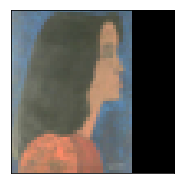

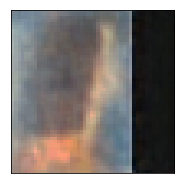

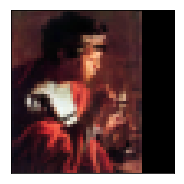

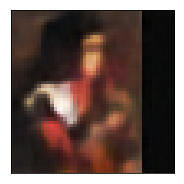

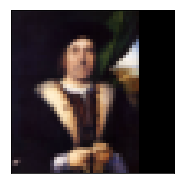

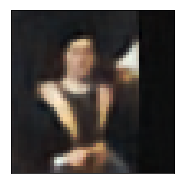

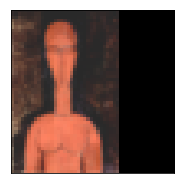

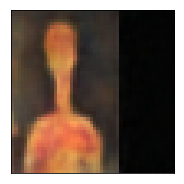

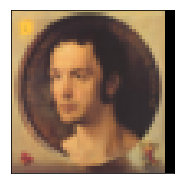

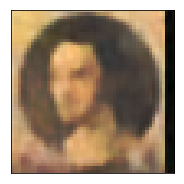

In [17]:
for i in range( 5 ):
    
    img = train[ i, :, :, : ]
    
    img = img * std + mu
        
        
        
    img = img - np.min( img )
        
    img = img / np.max( img )
        
    img = img * 255
        
    img = np.round( img )
        
    img = np.int32( img )
        
        
        
        
    plt.figure( figsize = ( 3, 3 ) )

    plt.imshow( img )

    plt.xticks( [] )

    plt.yticks( [] )    
    
    
    
    
    
    
    img = autoencoder.predict( [ train[ i, :, :, : ].reshape( [ 1, 50, 50, 3 ] ) ] )[ 0 ]
    
    img = img * std + mu
        
        
        
    img = img - np.min( img )
        
    img = img / np.max( img )
        
    img = img * 255
        
    img = np.round( img )
        
    img = np.int32( img )
        
        
        
        
    plt.figure( figsize = ( 3, 3 ) )

    plt.imshow( img )

    plt.xticks( [] )

    plt.yticks( [] )

Compared to [lesson 0042](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0042_art_generation.ipynb) the reproduction of the __train__ images improved.

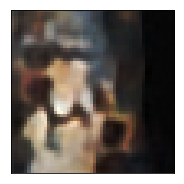

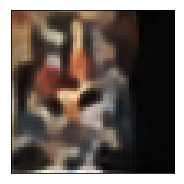

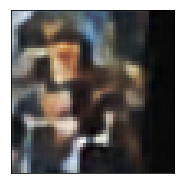

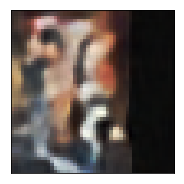

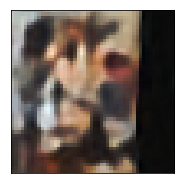

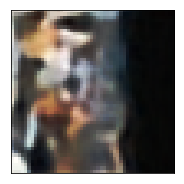

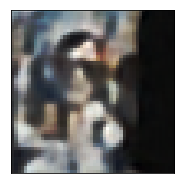

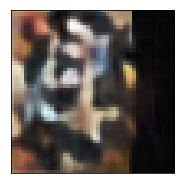

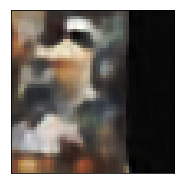

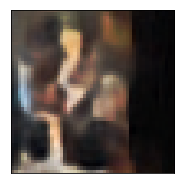

In [18]:
for i in range( 10 ):
    
    random_vector = stdd * np.random.randn( 1, 128 ) + mud
    
    random_vector = np.clip( random_vector, a_min = a_min, a_max = a_max )
    
    
    
        
    img = decoder.predict( random_vector )[ 0 ]
        
        
        
        
    img = img * std + mu
        
        
        
    img = img - np.min( img )
        
    img = img / np.max( img )
        
    img = img * 255
        
    img = np.round( img )
        
    img = np.int32( img )
        
        
        
        
    plt.figure( figsize = ( 3, 3 ) )

    plt.imshow( img )

    plt.xticks( [] )

    plt.yticks( [] )

The first, the third, the fourth, the fifth, the sixth, the seventh and the eighth picture portray humanlike objects.

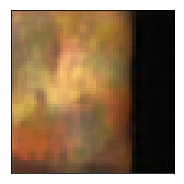

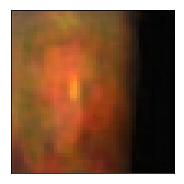

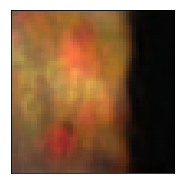

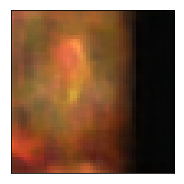

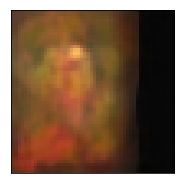

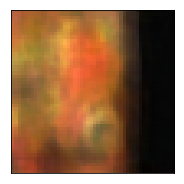

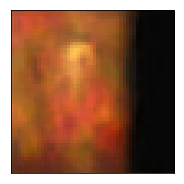

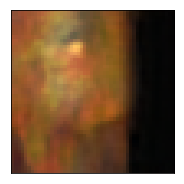

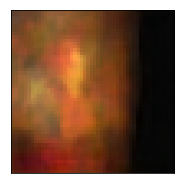

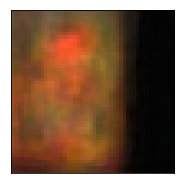

In [19]:
for i in range( 10 ):
    
    random_vector = stdd * 0.3 * np.random.randn( 1, 128 ) + mud
    
    random_vector = np.clip( random_vector, a_min = a_min, a_max = a_max )
    
    
    
        
    img = decoder.predict( random_vector )[ 0 ]
        
        
        
        
    img = img * std + mu
        
        
        
    img = img - np.min( img )
        
    img = img / np.max( img )
        
    img = img * 255
        
    img = np.round( img )
        
    img = np.int32( img )
        
        
        
        
    plt.figure( figsize = ( 3, 3 ) )

    plt.imshow( img )

    plt.xticks( [] )

    plt.yticks( [] )

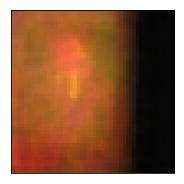

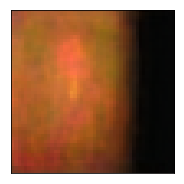

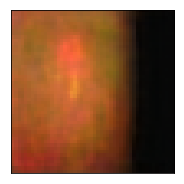

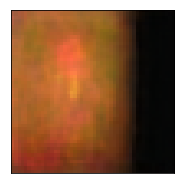

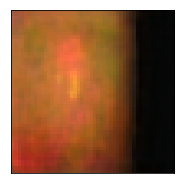

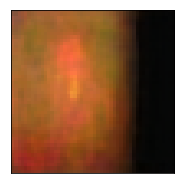

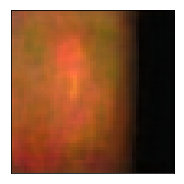

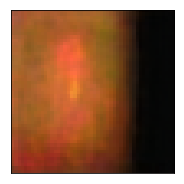

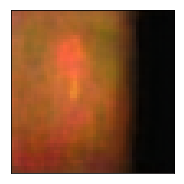

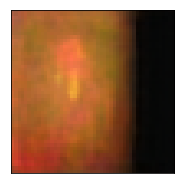

In [20]:
for i in range( 10 ):
    
    random_vector = stdd * 0.05 * np.random.randn( 1, 128 ) + mud
    
    random_vector = np.clip( random_vector, a_min = a_min, a_max = a_max )
    
    
    
        
    img = decoder.predict( random_vector )[ 0 ]
        
        
        
        
    img = img * std + mu
        
        
        
    img = img - np.min( img )
        
    img = img / np.max( img )
        
    img = img * 255
        
    img = np.round( img )
        
    img = np.int32( img )
        
        
        
        
    plt.figure( figsize = ( 3, 3 ) )

    plt.imshow( img )

    plt.xticks( [] )

    plt.yticks( [] )

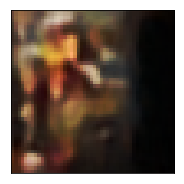

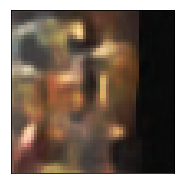

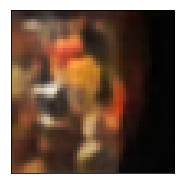

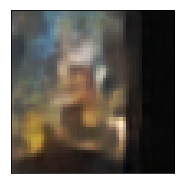

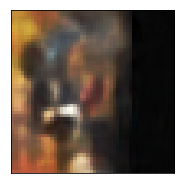

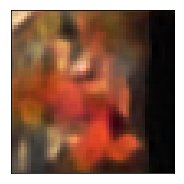

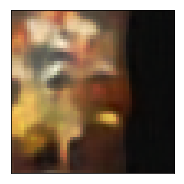

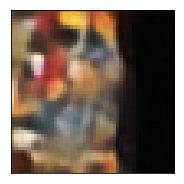

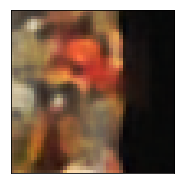

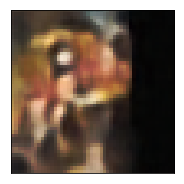

In [21]:
for i in range( 10 ):
    
    random_vector = stdd * 0.7 * np.random.randn( 1, 128 ) + mud
    
    random_vector = np.clip( random_vector, a_min = a_min, a_max = a_max )
    
    
    
        
    img = decoder.predict( random_vector )[ 0 ]
        
        
        
        
    img = img * std + mu
        
        
        
    img = img - np.min( img )
        
    img = img / np.max( img )
        
    img = img * 255
        
    img = np.round( img )
        
    img = np.int32( img )
        
        
        
        
    plt.figure( figsize = ( 3, 3 ) )

    plt.imshow( img )

    plt.xticks( [] )

    plt.yticks( [] )

The last two images portray humanlike objects.

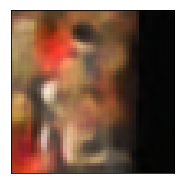

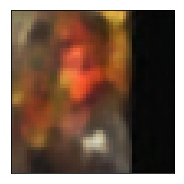

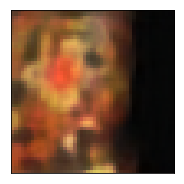

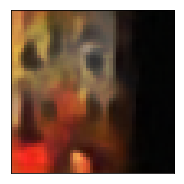

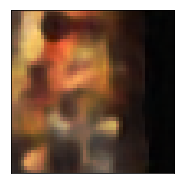

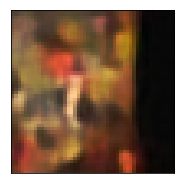

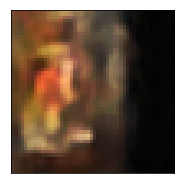

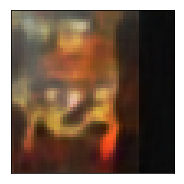

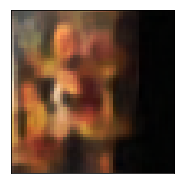

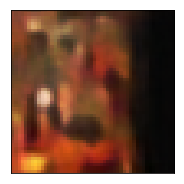

In [22]:
for i in range( 10 ):
    
    random_vector = stdd * 0.6 * np.random.randn( 1, 128 ) + mud
    
    random_vector = np.clip( random_vector, a_min = a_min, a_max = a_max )
    
    
    
        
    img = decoder.predict( random_vector )[ 0 ]
        
        
        
        
    img = img * std + mu
        
        
        
    img = img - np.min( img )
        
    img = img / np.max( img )
        
    img = img * 255
        
    img = np.round( img )
        
    img = np.int32( img )
        
        
        
        
    plt.figure( figsize = ( 3, 3 ) )

    plt.imshow( img )

    plt.xticks( [] )

    plt.yticks( [] )

Again, several pictures portray humanlike objects.<br>
We saw by tweaking the __learning rate__ we could improve the performance of the __autoencoder__.<br>
Class dismissed.